# Predicting Perception of IAQ
Adaptation of Mengjia Tang's analysis

# Library Import

## Basics

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import random

## SkLearn

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix

## Other

In [3]:
import shap

# Data Summary

In [4]:
df = pd.read_csv("../data/processed/iaq_perception-mt.csv")
df.head()

,Home_ID,FloorArea_sqft,CeilingHgt_ft,N_Bedrm,N_FullBath,N_HalfBath,Oven_Fuel,Num_Occupant,WHV_AsFound,AF1_Condition,...,NO2_AQL_IN1,FRM_ADJ_IN1,FRM_ADJ_BR1,T_ETC_IN1,RH_ETC_IN1,FRM_IN_ppb,NO2_IAQm_ppb,NOx_IAQm_ppb,Satisfaction_3points,Satisfaction_2points
0,1,2001,9,3,2,1,1,4.0,0.0,3.0,...,0.021302,10.522139,12.337049,23.269313,39.705435,14.252478,4.874853,20.336480,0,0
1,3,3104,10,4,3,0,0,2.0,1.0,1.0,...,0.048584,39.239283,42.685868,24.420784,45.021151,NaN,NaN,NaN,1,1
2,4,3248,11,3,3,1,0,2.0,0.0,1.0,...,0.153633,16.158558,16.637428,20.264354,45.067446,20.250339,1.708403,2.617361,1,1
3,5,2317,9,4,2,0,1,3.0,0.0,1.0,...,0.049589,23.635695,27.127771,25.372127,37.459627,NaN,2.776921,7.139446,0,0
4,6,3108,11,3,2,1,0,2.0,0.0,1.0,...,0.250460,27.351496,43.769564,25.585127,38.000461,44.742541,5.076926,25.850207,0,0


In [5]:
# Imputation with median
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
df_m = pd.DataFrame(data=imp_median.fit_transform(df),columns=df.columns)

## Building Characteristics

In [10]:
X1 = df_m.iloc[:,1:15]
X1.head()

,FloorArea_sqft,CeilingHgt_ft,N_Bedrm,N_FullBath,N_HalfBath,Oven_Fuel,Num_Occupant,WHV_AsFound,AF1_Condition,RHD_Grease_Screen_Condition,RHD_Fan_Airflow_Adjusted_Low_cfm,RHD_Fan_Airflow_Adjusted_High_cfm,EXF_BA1_Measured_cfm,Depressurization_Q50_cfm
0,2001.0,9.0,3.0,2.0,1.0,1.0,4.0,0.0,3.0,2.0,88.505747,133.333333,91.0,1006.0
1,3104.0,10.0,4.0,3.0,0.0,0.0,2.0,1.0,1.0,1.0,107.000000,326.000000,49.0,1548.5
2,3248.0,11.0,3.0,3.0,1.0,0.0,2.0,0.0,1.0,2.0,310.000000,1046.000000,101.0,2224.0
3,2317.0,9.0,4.0,2.0,0.0,1.0,3.0,0.0,1.0,1.0,81.609195,143.678161,81.5,1548.5
4,3108.0,11.0,3.0,2.0,1.0,0.0,2.0,0.0,1.0,1.0,360.000000,806.000000,81.0,1548.5


## Air Quality

In [12]:
X2 = df_m.iloc[:,15:27]
X2.head()

,PM_MET_IN1,PM_MET_OUT,CO2_ETC_IN1,CO2_ETC_BR1,NO2_AQL_IN1,FRM_ADJ_IN1,FRM_ADJ_BR1,T_ETC_IN1,RH_ETC_IN1,FRM_IN_ppb,NO2_IAQm_ppb,NOx_IAQm_ppb
0,2.011464,8.855427,640.476489,727.076213,0.021302,10.522139,12.337049,23.269313,39.705435,14.252478,4.874853,20.336480
1,5.959333,2.406069,830.593753,846.815114,0.048584,39.239283,42.685868,24.420784,45.021151,18.010887,5.502727,18.359575
2,11.291269,4.427615,512.227439,605.783042,0.153633,16.158558,16.637428,20.264354,45.067446,20.250339,1.708403,2.617361
3,1.074514,3.324214,671.966967,734.965862,0.049589,23.635695,27.127771,25.372127,37.459627,18.010887,2.776921,7.139446
4,3.883027,4.623322,603.374908,684.653495,0.250460,27.351496,43.769564,25.585127,38.000461,44.742541,5.076926,25.850207


## Target

In [13]:
Y1 = df_m.iloc[:,28]

---

# Feature Selection

In [21]:
def get_feature_importance(model,X_train,y_train):
    """
    Gets a DataFrame of the feature importances
    """
    try:
        model.fit(X_train,y_train)
        importances = pd.DataFrame(data={
            'Feature': X_train.columns,
            'Importance': model.feature_importances_
        })
        importances = importances.sort_values(by='Importance', ascending=False)
        return importances
    except:
        print("Not a valid model")
        return

## Standardizing Features

In [14]:
def scale_x(x,verbose=False):
    """
    Scales the given array
    """
    # scaling
    scaler = preprocessing.StandardScaler().fit(x)
    X_scaled = scaler.transform(x)
    
    # checking
    if verbose:
        print("Should be approximately zero:", X_scaled.mean(axis=0))
        print("Should be approximately one:",X_scaled.std(axis=0))
    
    return pd.DataFrame(data=X_scaled,columns=x.columns)

## Getting Complete Featureset
We include the features that Mengjia found relevant

In [15]:
X_all = df_m.iloc[:,np.r_[1:15,15:19,22:27]]
X_all.head()

,FloorArea_sqft,CeilingHgt_ft,N_Bedrm,N_FullBath,N_HalfBath,Oven_Fuel,Num_Occupant,WHV_AsFound,AF1_Condition,RHD_Grease_Screen_Condition,...,Depressurization_Q50_cfm,PM_MET_IN1,PM_MET_OUT,CO2_ETC_IN1,CO2_ETC_BR1,T_ETC_IN1,RH_ETC_IN1,FRM_IN_ppb,NO2_IAQm_ppb,NOx_IAQm_ppb
0,2001.0,9.0,3.0,2.0,1.0,1.0,4.0,0.0,3.0,2.0,...,1006.0,2.011464,8.855427,640.476489,727.076213,23.269313,39.705435,14.252478,4.874853,20.336480
1,3104.0,10.0,4.0,3.0,0.0,0.0,2.0,1.0,1.0,1.0,...,1548.5,5.959333,2.406069,830.593753,846.815114,24.420784,45.021151,18.010887,5.502727,18.359575
2,3248.0,11.0,3.0,3.0,1.0,0.0,2.0,0.0,1.0,2.0,...,2224.0,11.291269,4.427615,512.227439,605.783042,20.264354,45.067446,20.250339,1.708403,2.617361
3,2317.0,9.0,4.0,2.0,0.0,1.0,3.0,0.0,1.0,1.0,...,1548.5,1.074514,3.324214,671.966967,734.965862,25.372127,37.459627,18.010887,2.776921,7.139446
4,3108.0,11.0,3.0,2.0,1.0,0.0,2.0,0.0,1.0,1.0,...,1548.5,3.883027,4.623322,603.374908,684.653495,25.585127,38.000461,44.742541,5.076926,25.850207


#### Splitting

In [82]:
X_scaled_all = scale_x(X_all)
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_scaled_all, Y1, test_size = 0.1, random_state=0)

## Gridsearch for Optimal DT and RF Parameters
We need to somewhat optimize the DT and RF models to the entire featureset so that we are at more aptly determining the important features.

### DT

In [18]:
fs_DT = DecisionTreeClassifier(random_state=42)
parameters = {'ccp_alpha':np.arange(0,0.1,0.005),'criterion':['entropy',"gini"],'max_depth':np.arange(3,9,1)}
fs_DT_grid = GridSearchCV(fs_DT, parameters, cv=10, refit=True, scoring='accuracy')
fs_DT_grid.fit(X_train_all, y_train_all)
for key, val in fs_DT.best_params_.items():
    print(f"{key}: {val}")

ccp_alpha: 0.0
criterion: entropy
max_depth: 8


### RF

In [19]:
fs_RF = RandomForestClassifier(random_state=42)
parameters = {'ccp_alpha':np.arange(0,0.05,0.005),'criterion':['entropy','gini'],'max_depth':np.arange(3,9,1),'n_estimators':[10,20,50,100]}
fs_RF_grid = GridSearchCV(fs_RF, parameters, cv=10, refit=True,scoring='accuracy')
fs_RF_grid.fit(X_train_all, y_train_all)
for key, val in fs_RF_grid.best_params_.items():
    print(f"{key}: {val}")

ccp_alpha: 0.0
criterion: gini
max_depth: 6
n_estimators: 50


## Feature Importances
Using the optimized models from above to get the important features

See some good articles here about SHAP values - **NOT USED**:
* [RF Models](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)
* [Other Models](https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a)

And the [Github](https://github.com/slundberg/shap) for this library.

### DT

In [24]:
fs_DT_imp = get_feature_importance(DecisionTreeClassifier(random_state=42,ccp_alpha=0.0,criterion="entropy",max_depth=8),
                                   X_train_all,y_train_all)
fs_DT_imp[:10]

,Feature,Importance
17,CO2_ETC_BR1,0.266724
19,RH_ETC_IN1,0.225970
10,RHD_Fan_Airflow_Adjusted_Low_cfm,0.149999
14,PM_MET_IN1,0.110046
20,FRM_IN_ppb,0.103581
22,NOx_IAQm_ppb,0.077674
18,T_ETC_IN1,0.066006
12,EXF_BA1_Measured_cfm,0.000000
21,NO2_IAQm_ppb,0.000000
16,CO2_ETC_IN1,0.000000


### RF

In [26]:
fs_RF_imp = get_feature_importance(RandomForestClassifier(random_state=42,ccp_alpha=0.0,criterion="gini",max_depth=6,n_estimators=50),
                                   X_train_all,y_train_all)
fs_RF_imp[:10]

,Feature,Importance
13,Depressurization_Q50_cfm,0.090587
10,RHD_Fan_Airflow_Adjusted_Low_cfm,0.085150
16,CO2_ETC_IN1,0.079898
20,FRM_IN_ppb,0.069125
12,EXF_BA1_Measured_cfm,0.062588
21,NO2_IAQm_ppb,0.061923
17,CO2_ETC_BR1,0.054882
19,RH_ETC_IN1,0.054273
0,FloorArea_sqft,0.050950
14,PM_MET_IN1,0.048619


## Defining Important Features as ```X```
From the results above, we get the important features:

In [27]:
X = df_m[[col for col in ["CO2_ETC_BR1","RH_ETC_IN1","PM_MET_IN1","NO2_IAQm_ppb","FRM_IN_ppb","T_ETC_IN1",
                          "RHD_Fan_Airflow_Adjusted_Low_cfm","Depressurization_Q50_cfm","EXF_BA1_Measured_cfm"]]]
X.head()

,CO2_ETC_BR1,RH_ETC_IN1,PM_MET_IN1,NO2_IAQm_ppb,FRM_IN_ppb,T_ETC_IN1,RHD_Fan_Airflow_Adjusted_Low_cfm,Depressurization_Q50_cfm,EXF_BA1_Measured_cfm
0,727.076213,39.705435,2.011464,4.874853,14.252478,23.269313,88.505747,1006.0,91.0
1,846.815114,45.021151,5.959333,5.502727,18.010887,24.420784,107.000000,1548.5,49.0
2,605.783042,45.067446,11.291269,1.708403,20.250339,20.264354,310.000000,2224.0,101.0
3,734.965862,37.459627,1.074514,2.776921,18.010887,25.372127,81.609195,1548.5,81.5
4,684.653495,38.000461,3.883027,5.076926,44.742541,25.585127,360.000000,1548.5,81.0


<div class="alert alert-block alert-info">
 
We have 9 features to include:
* IAQ: CO2 (bedroom), RH, PM, NO2, HCHO, T
* HVAC: Fan airflow, Q50, Exfiltration (bathroom)
    
</div>

In [28]:
X_scaled = scale_x(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y1, test_size = 0.1, random_state=0)

---

# Defining Full Model
To compare, we need to generate the full model

## Tuning Hyperparameters

### LR

In [34]:
def optimize_lr(X,y):
    """
    optimizes the LR parameters
    """
    test_LR = LogisticRegression(random_state=0)
    parameters = {'fit_intercept':[True,False],"solver":["lbfgs","liblinear"]}
    test_LR_grid = GridSearchCV(test_LR, parameters, cv=10, refit=True, scoring='accuracy')
    test_LR_grid.fit(X, y)
    for key, val in test_LR_grid.best_params_.items():
        print(f"{key}: {val}")

In [35]:
optimize_lr(X_train_all,y_train_all)

fit_intercept: False
solver: lbfgs


In [36]:
model_LR_full = LogisticRegression(random_state=42,fit_intercept=False,solver="lbfgs")

### DT

In [44]:
def optimize_dt(X,y):
    """
    optimizes parameters for DT model
    """
    test_DT = DecisionTreeClassifier(random_state=0)
    parameters = {'ccp_alpha':np.arange(0,0.1,0.005),'criterion':['entropy',"gini"],'max_depth':np.arange(2,11,1)}
    test_DT_grid = GridSearchCV(test_DT, parameters, cv=10, refit=True,scoring='accuracy')
    test_DT_grid.fit(X, y)
    for key, val in test_DT_grid.best_params_.items():
        print(f"{key}: {val}")

In [45]:
optimize_dt(X_train_all,y_train_all)

ccp_alpha: 0.04
criterion: entropy
max_depth: 9


In [52]:
model_DT_full = DecisionTreeClassifier(random_state=42,ccp_alpha=0.04,criterion="entropy",max_depth=9)

### RF

In [50]:
def optimize_rf(X,y):
    """
    optimizes parameters for RF model
    """
    test_RF = RandomForestClassifier(random_state=0)
    parameters = {'ccp_alpha':np.arange(0,0.05,0.005),'criterion':['entropy','gini'],'max_depth':np.arange(3,9,1),'n_estimators':[10,20,50,100]}
    test_RF_grid = GridSearchCV(test_RF, parameters, cv=10, refit=True,scoring='accuracy')
    test_RF_grid.fit(X, y)
    for key, val in test_RF_grid.best_params_.items():
        print(f"{key}: {val}")

In [51]:
optimize_rf(X_train_all,y_train_all)

ccp_alpha: 0.0
criterion: gini
max_depth: 6
n_estimators: 50


In [53]:
model_RF_full = RandomForestClassifier(random_state=42,ccp_alpha=0.0,criterion="gini",max_depth=6,n_estimators=50)

## Defining

In [54]:
models_full = {"LR":model_LR_full,"DT":model_DT_full,"NB":GaussianNB(),"RF":model_RF_full}

---

# Defining Lite Model
Now that we have the important features, we need to tune the models

## Tuning Hyperparameters

### Logistic Regression

In [55]:
optimize_lr(X_train,y_train)

fit_intercept: False
solver: lbfgs


In [56]:
model_LR_lite = LogisticRegression(random_state=42,fit_intercept=False,solver="lbfgs")

### Decision Tree

In [57]:
optimize_dt(X_train,y_train)

ccp_alpha: 0.0
criterion: entropy
max_depth: 8


In [58]:
model_DT_lite = DecisionTreeClassifier(random_state=42,ccp_alpha=0.0,criterion="entropy",max_depth=8)

### Random Forest

In [59]:
optimize_rf(X_train,y_train)

ccp_alpha: 0.0
criterion: entropy
max_depth: 8
n_estimators: 20


In [60]:
model_RF_lite = RandomForestClassifier(random_state=42,ccp_alpha=0.0,criterion="entropy",max_depth=8,n_estimators=20)

## Defining

In [61]:
models_lite = {"LR":model_LR_lite,"DT":model_DT_lite,"NB":GaussianNB(),"RF":model_RF_lite}

---

# Comparing Lite and Full Models
Following Mengjia's analysis, we compare the accuracy and CV from the lite and full models.

## Lite

In [69]:
for label, model in models_lite.items(): 
    print(label,model)

LR LogisticRegression(fit_intercept=False, random_state=42)
DT DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=42)
NB GaussianNB()
RF RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=20,
                       random_state=42)


In [81]:
res_lite = {"model":[],"cv_mean":[],"cv_std":[],"accuracy":[]}
preds_lite = {"model":[],"predictions":[]}
for label, model in models_lite.items():
    # CV score
    cv_score = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    
    # Prediction accuracy
    model.fit(X_train, y_train)
    pred_lite = model.predict(X_test)
    ## saving to dict
    preds_lite["model"].append(label)
    preds_lite["predictions"].append(pred_lite)
    
    # Updating comparison dict
    for key, val in zip(res_lite.keys(),[label,cv_score.mean(),cv_score.std(),accuracy_score(pred_lite,y_test)]):
        res_lite[key].append(val)
        
res_lite_df = pd.DataFrame(res_lite)

## Full

In [78]:
res_full = {"model":[],"cv_mean":[],"cv_std":[],"accuracy":[]}
for label, model in models_full.items():
    # CV score
    cv_score = cross_val_score(model, X_train_all, y_train_all, cv=10, scoring='accuracy')
    
    # Prediction accuracy
    model.fit(X_train_all, y_train_all)
    pred_full = model.predict(X_test_all)
    
    # Updating comparison dict
    for key, val in zip(res_lite.keys(),[label,cv_score.mean(),cv_score.std(),accuracy_score(pred_full,y_test)]):
        res_full[key].append(val)
        
res_full_df = pd.DataFrame(res_full)

## Comparison

In [79]:
res_lite_df

,model,cv_mean,cv_std,accuracy
0,LR,0.5750,0.150000,0.555556
1,DT,0.7125,0.194052,0.666667
2,NB,0.5750,0.217945,0.777778
3,RF,0.5875,0.216867,0.888889


In [80]:
res_full_df

,model,cv_mean,cv_std,accuracy
0,LR,0.5500,0.150000,0.555556
1,DT,0.6625,0.185826,0.777778
2,NB,0.6250,0.185405,0.666667
3,RF,0.5750,0.139194,0.777778


## Check with Random Targets

In [85]:
res_random_full = {"model":[],"cv_mean":[],"accuracy":[]}

for i in range(10):
    Y_random = np.array(random.sample(list(Y1), len(Y1)))
    X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(X_scaled_all, Y_random, test_size=0.1)
    for label, model in models_full.items():

        # train model
        model.fit(X_train_rand,y_train_rand)

        # cross validate model with 10-fold cv
        cv_mean = cross_val_score(model, X_train_rand, y_train_rand, cv=10).mean()

        # accuracy
        acc = model.score(X_test_rand,y_test_rand)
        
        # update dict
        for key, val in zip(res_random_full.keys(),[label,cv_mean,acc]):
            res_random_full[key].append(val)

In [94]:
res_random_full_avg = pd.DataFrame(res_random_full).groupby("model").mean()
res_random_full_avg

,cv_mean,accuracy
model,,
DT,0.47250,0.422222
LR,0.48250,0.511111
NB,0.47625,0.533333
RF,0.49875,0.455556


---

# Evaluation

## Metrics

In [185]:
for label, predictions in res.items():
    print(label,accuracy_score(predictions,y_test))

LR 0.6666666666666666
DT 0.7777777777777778
NB 0.4444444444444444
RF 0.7777777777777778


---

# Figures

In [95]:
# plot
archive = True
if not archive:
    x = df.iloc[:,14] #Depression
    y = df.iloc[:,11] #RHD_Low
    z = df.iloc[:,23] #RH
    target = df.iloc[:,28]
    fig, ax = plt.subplots(frameon=False)
    fig.set_size_inches(8,6)
    mi = np.min(z)
    ma = np.max(z)
    norm = matplotlib.colors.Normalize(vmin=mi,vmax=ma)
    ax.scatter(x[target==0], y[target==0], alpha=0.6, c=z[target==0], cmap='jet',marker='o',s=100,norm=norm, label = 'Class 0')
    im=ax.scatter(x[target==1], y[target==1], alpha=0.6, c=z[target==1], cmap='jet',marker='^',s=100,norm=norm, label = 'Class 1')
    cbar = fig.colorbar(im, ax=ax)
    cbar.solids.set(alpha=0.6)
    cbar.ax.set_ylabel('RH (%)',fontsize=18)
    cbar.ax.tick_params(labelsize=14)
    plt.xlabel('Q50 (cfm)',fontsize=18)
    plt.ylabel('RHD_Low (cfm)',fontsize=18)
    ax.legend(fontsize=18,loc='upper left')
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.xlim(0,  3500)
    plt.ylim(-5,  350)
    #plt.savefig('pic2.png', dpi=150)

## Feature Correlation

In [97]:
X.head()

,CO2_ETC_BR1,RH_ETC_IN1,PM_MET_IN1,NO2_IAQm_ppb,FRM_IN_ppb,T_ETC_IN1,RHD_Fan_Airflow_Adjusted_Low_cfm,Depressurization_Q50_cfm,EXF_BA1_Measured_cfm
0,727.076213,39.705435,2.011464,4.874853,14.252478,23.269313,88.505747,1006.0,91.0
1,846.815114,45.021151,5.959333,5.502727,18.010887,24.420784,107.000000,1548.5,49.0
2,605.783042,45.067446,11.291269,1.708403,20.250339,20.264354,310.000000,2224.0,101.0
3,734.965862,37.459627,1.074514,2.776921,18.010887,25.372127,81.609195,1548.5,81.5
4,684.653495,38.000461,3.883027,5.076926,44.742541,25.585127,360.000000,1548.5,81.0


In [101]:
X_df

,CO$_2$ (BR),RH,PM,NO$_2$,FRM,T,Fan Airflow,Q50,Exfiltration (BA)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


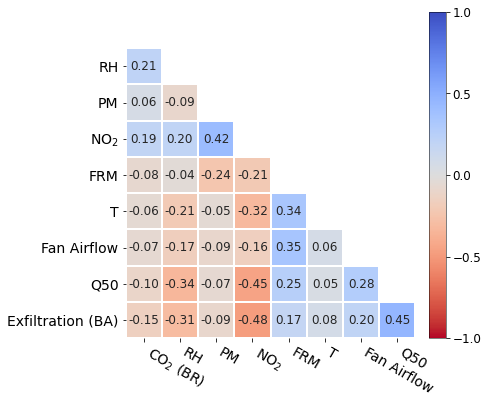

In [158]:
_, ax = plt.subplots(figsize=(8,6)) 
X_df = X.copy()
X_df.columns = ["CO$_2$ (BR)", "RH", "PM", "NO$_2$", "FRM", "T", "Fan Airflow","Q50", "Exfiltration (BA)"]
corr = X_df.corr()
# generating a mask for upper only
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
# plotting
sns.heatmap(corr,vmin=-1,vmax=1,lw=2,mask=mask,square=True,
            annot_kws={'size':12},fmt=".2f",annot=True,
            cmap="coolwarm_r",cbar_kws={"ticks":np.arange(-1,1.5,0.5),"pad":-0.05},ax=ax)
# formatting x
ax.set_xticks(np.arange(0.5,len(X_df.columns)-1,1))
ax.set_xticklabels(X_df.columns[:-1],rotation=-30,ha="left",fontsize=14)
# formatting y
ax.set_yticks(np.arange(1.5,len(X_df.columns),1))
ax.set_yticklabels(X_df.columns[1:],fontsize=14)
# colorbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.outline.set_color('black')
cbar.outline.set_linewidth(0.5)

#plt.savefig('heatmap.png', dpi=150)
plt.show()
plt.close()